In [1]:
import json
import os
import numpy as np
import torch as t
import torch.nn.functional as F
from collections import defaultdict
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from cluster_utils import ClusterConfig, pos_filter_sparse;

/home/can/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results_dir = "/home/can/feature_clustering/clustering_pythia-70m-deduped_tloss0.1_nsamples1024_npos32_filtered-induction_mlp-attn-resid"

# Load config
device = "cuda:0"
ccfg = ClusterConfig(**json.load(open(os.path.join(results_dir, "config.json"), "r")))

In [3]:
def load_pattern_matrix_final_pos(results_dir, data_source, ccfg):
    pos_idxs = [ccfg.n_pos - 1]
    X = t.load(os.path.join(results_dir, data_source + ".pt"))
    X = pos_filter_sparse(X, ccfg, pos_idxs)
    X = X.to_dense().reshape(X.shape[0], -1)
    return X

def compute_similarity_matrix(X, angular=False):
    X_norm = F.normalize(X, p=2, dim=-1)
    C = t.matmul(X_norm, X_norm.T) # cos sim
    if angular:
        C = t.clamp(C, -1, 1)
        C = 1 - t.acos(C) / np.pi
    return C

def compute_similarity_matrix_between_clusters(X, cluster_1_idxs, cluster_2_idxs, angular=False):
    X_norm = F.normalize(X, p=2, dim=-1)
    C = t.matmul(X_norm[cluster_1_idxs], X_norm[cluster_2_idxs].T) # cos sim
    if angular:
        C = t.clamp(C, -1, 1)
        C = 1 - t.acos(C) / np.pi
    return C

def find_pairwise_distances(X, angular=False):
    C = compute_similarity_matrix(X, angular=angular)
    # Only select values in the upper triangle
    distances = []
    for row in range(C.shape[0]):
        for col in range(row+1, C.shape[1]):
            distances.append(C[row, col].item())
    return t.tensor(distances)

def find_centroids(X, clusters, n_clusters):
    centroid_idxs = t.zeros(n_clusters, dtype=t.int)
    for cluster_idx in range(n_clusters):
        cluster_mask = t.tensor(clusters[str(n_clusters)]) == cluster_idx
        cluster = X[cluster_mask]
        cluster_mean = cluster.mean(dim=0)
        distances = t.norm(cluster - cluster_mean, dim=1)
        centroid_idx = t.argsort(distances)[0]
        centroid_idxs[cluster_idx] = centroid_idx
    return centroid_idxs

## Activations

In [4]:
data_source = "activations" # activations or lin_effects
cluster_filename = f"clusters_activations_posfinal.json"
activation_clusters = json.load(open(os.path.join(results_dir, cluster_filename), "r"))
X_activations = load_pattern_matrix_final_pos(results_dir, data_source, ccfg)

In [5]:
# Inspect single cluster
n_clusters = 50
cluster_idx = 0

cluster_mask = t.tensor(activation_clusters[str(n_clusters)]) == cluster_idx
pairwise_distances = find_pairwise_distances(X_activations[cluster_mask], angular=False)

print(f'cluster {n_clusters}/{cluster_idx} has {cluster_mask.sum()} samples')
print(f'unique distances {pairwise_distances.unique()}')

cluster 50/0 has 16 samples
unique distances tensor([1.0000])


In [7]:
# Compute intra-cluster distances for all n_clusters
aggregated_intra_cluster_distances = defaultdict(list)
for i, n_clusters in enumerate(ccfg.cluster_counts):
    for cluster_idx in range(n_clusters):
        cluster_mask = t.tensor(activation_clusters[str(n_clusters)]) == cluster_idx
        if cluster_mask.sum() > 1:
            pairwise_distances = find_pairwise_distances(X_activations[cluster_mask], angular=False)
            aggregated_intra_cluster_distances[n_clusters].append((pairwise_distances.mean(), cluster_idx, cluster_mask.sum()))

In [15]:
aggregated_intra_cluster_distances[100]

[(tensor(1.0000), 0, tensor(16)),
 (tensor(1.0000), 1, tensor(16)),
 (tensor(1.), 2, tensor(16)),
 (tensor(1.0000), 3, tensor(16)),
 (tensor(1.), 4, tensor(16)),
 (tensor(1.), 5, tensor(16)),
 (tensor(1.0000), 6, tensor(16)),
 (tensor(1.0000), 7, tensor(16)),
 (tensor(1.0000), 8, tensor(16)),
 (tensor(1.0000), 9, tensor(16)),
 (tensor(1.), 10, tensor(16)),
 (tensor(1.0000), 11, tensor(16)),
 (tensor(1.0000), 12, tensor(16)),
 (tensor(0.9993), 13, tensor(17)),
 (tensor(1.0000), 14, tensor(16)),
 (tensor(1.0000), 15, tensor(16)),
 (tensor(1.0000), 16, tensor(16)),
 (tensor(1.0000), 17, tensor(16)),
 (tensor(1.0000), 18, tensor(16)),
 (tensor(1.0000), 19, tensor(14)),
 (tensor(1.0000), 20, tensor(16)),
 (tensor(1.0000), 21, tensor(16)),
 (tensor(1.0000), 22, tensor(16)),
 (tensor(1.0000), 23, tensor(16)),
 (tensor(1.0000), 24, tensor(16)),
 (tensor(1.0000), 25, tensor(14)),
 (tensor(0.9771), 26, tensor(17)),
 (tensor(1.0000), 27, tensor(16)),
 (tensor(1.0000), 28, tensor(16)),
 (tensor(1.

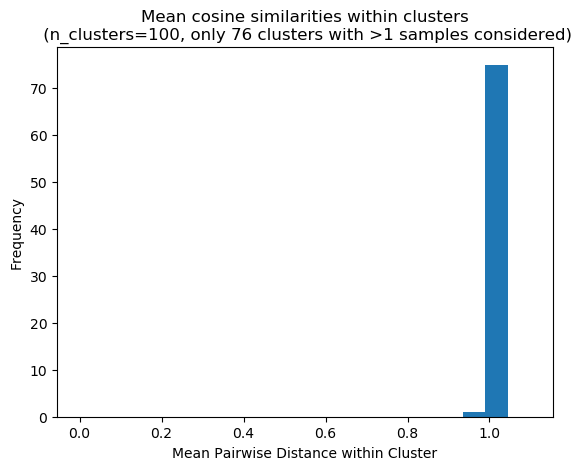

In [24]:
# Get the distances
distances = t.tensor(aggregated_intra_cluster_distances[100])[:, 0]

# Plot the histogram
xmax = 1.1
nbins = 20
plt.hist(distances, bins=nbins, range=(0, xmax))
plt.xlabel('Mean Pairwise Distance within Cluster')
plt.ylabel('Frequency')
plt.title(f'Mean cosine similarities within clusters\n (n_clusters=100, only {distances.shape[0]} clusters with >1 samples considered)')

# Show the plot
plt.show()

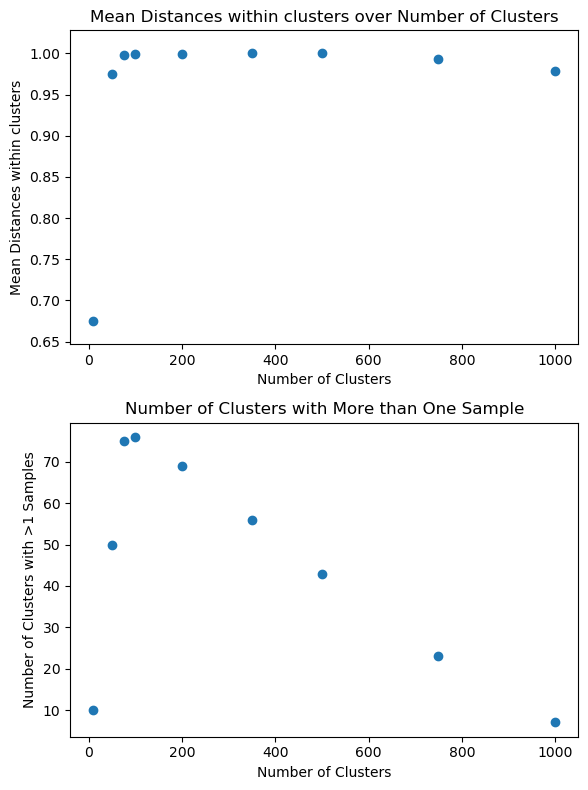

In [59]:
# Get the data
mean_distances = [t.tensor(agg)[:, 0].mean() for n_clusters, agg in aggregated_intra_cluster_distances.items()]
num_clusters = [t.tensor(agg).shape[0] for n_clusters, agg in aggregated_intra_cluster_distances.items()]

# Create the figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(6,8))

# Plot the mean intra-cluster distances
axs[0].scatter(ccfg.cluster_counts, mean_distances)
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Mean Distances within clusters')
axs[0].set_title('Mean Distances within clusters over Number of Clusters')

# Plot the number of clusters with more than one sample
axs[1].scatter(ccfg.cluster_counts, num_clusters)
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Number of Clusters with >1 Samples')
axs[1].set_title('Number of Clusters with More than One Sample')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


what's the cluster above about? (choose not to append single values)

In [21]:

for i, n_clusters in enumerate(ccfg.cluster_counts):
    for cluster_idx in range(n_clusters):
        cluster_mask = t.tensor(activation_clusters[str(n_clusters)]) == cluster_idx
        # if cluster_mask.sum() > 0:
        pairwise_distances = find_pairwise_distances(X_activations[cluster_mask], angular=False)
        aggregated_intra_cluster_distances[n_clusters].append(pairwise_distances.mean().item())

In [22]:
t.tensor(aggregated_intra_cluster_distances[10]).mean()

tensor(0.6749)

In [ ]:
centroid_pairwise_distances = defaultdict(list)
for n_clusters in ccfg.cluster_counts:
    centroid_idxs = find_centroids(X_activations, activation_clusters, n_clusters)
    centroid_pairwise_distances[n_clusters].append(find_pairwise_distances(X_activations[centroid_idxs], angular=False).tolist())

In [ ]:
def plot_intra_cluster_distances(accumulated_intra_cluster_distances, centroid_pairwise_distances):    
    # Plot intra-cluster distances
    fig = go.Figure()

    # Create slider steps
    slider_steps = []
    for n_clusters, intra_cluster_distances in accumulated_intra_cluster_distances.items():
        slider_step = dict(
            method="update",
            label=f"{n_clusters} clusters",
            args=[{"visible": [False] * (len(accumulated_intra_cluster_distances) + 1)}]  # Hide all traces
        )
        slider_step["args"][0]["visible"][list(accumulated_intra_cluster_distances.keys()).index(n_clusters) + 1] = True  # Show selected trace
        slider_steps.append(slider_step)

    # Add histogram traces for intra-cluster distances
    for n_clusters, intra_cluster_distances in accumulated_intra_cluster_distances.items():
        n_bins = 20
        binsize = 1 / n_bins
        fig.add_trace(go.Histogram(x=intra_cluster_distances, histnorm='probability', name=f'{n_clusters} clusters', nbinsx=n_bins, xbins=dict(size=binsize), visible=False))

    # Set initial visibility
    fig.data[0].visible = True

    # Create slider
    fig.update_layout(
        sliders=[dict(
            active=0,
            currentvalue={"prefix": "Number of clusters: "},
            steps=slider_steps,
            y=-0.15,  # Adjust the y position of the slider
            len=1  # Adjust the length of the slider
        )]
    )

    # Set layout
    fig.update_layout(
        barmode='overlay',
        xaxis_title="Pairwise distance",
        yaxis_title="Probability",
        title="Intra-cluster distances",
        xaxis=dict(
            title=dict(
                text="Pairwise distance",
                standoff=15
            ),
            range=[0, 1]  # Set the x-axis range between 0 and 1
        ),
        yaxis=dict(
            range=[0, 1]  # Set the x-axis range between 0 and 1
        )
    )
    fig.update_traces(opacity=0.75)
    return fig

In [ ]:
fig = plot_intra_cluster_distances(accumulated_intra_cluster_distances, centroid_pairwise_distances)
fig.show()

In [ ]:
n_clusters = 500

# Plotting histograms of pairwise distances for centroids and a specific intracluster
plt.figure(figsize=(10, 6))

# Adding histogram for centroids pairwise distances
centroid_idxs = find_centroids(X_activations, activation_clusters, n_clusters)
pairwise_distances_centroids = find_pairwise_distances(X_activations[centroid_idxs], angular=False)
plt.hist(pairwise_distances_centroids.flatten(), bins=100, alpha=0.5, label='Centroids of all clusters', density=True)

# Adding histogram for intracluster pairwise distances
for cluster_idx in range(n_clusters):
    cluster_mask = t.tensor(activation_clusters[str(n_clusters)]) == cluster_idx
    cluster = X_activations[cluster_mask]
    pairwise_distances_intracluster = find_pairwise_distances(cluster, angular=False)
    plt.hist(pairwise_distances_intracluster.flatten(), bins=100, alpha=0.5, label=f'Cluster {cluster_idx}', density=True)

# Set labels and title
plt.xlabel('Pairwise Cosine similarity')
plt.ylabel('Ratio of distance in histogram bin')
plt.title('Pairwise Distances: Intracluster vs. Centroids')

# Show legend
# plt.legend()

# Show the plot
plt.show()

## Linear Effects

In [ ]:
data_source = "lin_effects" # activations or lin_effects
cluster_filename = f"clusters_lin_effects_posfinal.json"
lin_effect_clusters = json.load(open(os.path.join(results_dir, cluster_filename), "r"))
X_lin_eff = load_pattern_matrix_final_pos(results_dir, data_source, ccfg)

In [ ]:
n_clusters = 500

# Plotting histograms of pairwise distances for centroids and a specific intracluster
plt.figure(figsize=(10, 6))

# Adding histogram for centroids pairwise distances
centroid_idxs = find_centroids(X_lin_eff, lin_effect_clusters, n_clusters)
pairwise_distances_centroids = find_pairwise_distances(X_lin_eff[centroid_idxs], angular=False)
plt.hist(pairwise_distances_centroids.flatten(), bins=100, alpha=0.5, label='Centroids of all clusters', density=True)

# Adding histogram for intracluster pairwise distances
for cluster_idx in range(n_clusters):
    cluster_mask = t.tensor(lin_effect_clusters[str(n_clusters)]) == cluster_idx
    cluster = X_lin_eff[cluster_mask]
    pairwise_distances_intracluster = find_pairwise_distances(cluster, angular=False)
    plt.hist(pairwise_distances_intracluster.flatten(), bins=100, alpha=0.5, label=f'Cluster {cluster_idx}', density=True)

# Set labels and title
plt.xlabel('Pairwise Cosine similarity')
plt.ylabel('Ratio of distance in histogram bin')
plt.title('Pairwise Distances: Intracluster vs. Centroids')

# Show legend
# plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plotly histogram with slider for n_clusters
fig = go.Figure()


In [ ]:
# Plotting histograms of pairwise distances for centroids and a specific intracluster
# fig = go.Figure()
# # Adding histogram for centroids pairwise distances
# fig.add_trace(go.Histogram(x=pairwise_distances_centroids.flatten(), name='Centroids of all clusters', histnorm='probability', nbinsx=100))

# # Adding histogram for intracluster pairwise distances
# for cluster_idx in range(n_clusters):
#     cluster_mask = t.tensor(clusters[str(n_clusters)]) == cluster_idx
#     cluster = X[cluster_mask]
#     pairwise_distances_intracluster = find_pairwise_distances(cluster, angular=False)
#     # if t.all(pairwise_distances_intracluster > 0):
#     fig.add_trace(go.Histogram(x=pairwise_distances_intracluster.flatten(), name= f'Cluster {cluster_idx}', histnorm='probability', nbinsx=100))


# # Update layout for clarity
# fig.update_layout(barmode='overlay',  # Overlay both histograms
#                   title_text='Pairwise Distances: Intracluster vs. Centroids',  # Title
#                   xaxis_title_text='Pairwise Cosine similarity',  # X-axis label
#                   yaxis_title_text='Ratio of distance in histogram bin',  # Y-axis label
#                   legend_title_text='Clusters')  # Legend title
# fig.update_traces(opacity=0.75)  # Set opacity to differentiate the overlaid histograms

# fig.show()

## Pairwise between random pattern vectors in X

In [ ]:
# Compute random cosine similarities of X columns
n_tries = 10000

cos_sim_random_pairs = t.zeros(n_tries)
for i in range(n_tries):
    idxs = np.random.choice(X_activations.shape[0], 2, replace=False)
    cos_sim_random_pairs[i] = t.cosine_similarity(X_activations[idxs[0]], X_activations[idxs[1]], dim=-1)

In [ ]:
# Plotting histograms of pairwise distances for centroids and a specific intracluster
plt.figure(figsize=(10, 6))

# Adding histogram for centroids pairwise distances
plt.hist(cos_sim_random_pairs, bins=100, alpha=0.5, density=True)

# Set labels and title
plt.xlabel('Pairwise Cosine similarity')
plt.ylabel('Ratio of distance in histogram bin')
plt.title('Cosine sim of random pairs of feature pattern vectors')
plt.xlim(cos_sim_random_pairs.min(), 1)

# Show the plot
plt.show()

# Random vector for comparison

In [ ]:
X_rand = np.random.rand(1000, 10000) * 2 - 1

In [ ]:
pairwise_random_distances = find_pairwise_distances(t.tensor(X_rand), angular=False)

In [ ]:
plt.hist(pairwise_random_distances.flatten(), bins=100, alpha=0.5, label='Random');
plt.xlim([-.005,1])

In [ ]:
# Plotting histograms of pairwise distances for centroids and a specific intracluster
fig = go.Figure()
# Adding histogram for centroids pairwise distances
fig.add_trace(go.Histogram(x=pairwise_random_distances.flatten(), name='Random Vectors', histnorm='probability', nbinsx=100))
# Update layout for clarity
fig.update_layout(barmode='overlay',  # Overlay both histograms
                  title_text='Pairwise Distances: of random dense vectors in high dimensional space',  # Title
                  xaxis_title_text='Pairwise Cosine similarity',  # X-axis label
                  yaxis_title_text='Ratio of distance in histogram bin',  # Y-axis label
                  legend_title_text='Sets')  # Legend title
fig.update_traces(opacity=0.75)  # Set opacity to differentiate the overlaid histograms

fig.show()

Sanity check:
Does the clustering algorithm pick up on clusters 


In [ ]:
# Load samples
samples = json.load(open(os.path.join(results_dir, "samples.json"), "r"))

# Filter samples for cluster 0
sample_mask = t.arange(X.shape[0])[t.tensor(clusters[str(n_clusters)]) == 0]

In [ ]:
from transformers import AutoTokenizer

# Load samples
resdir = "/home/can/feature_clustering/clustering_pythia-70m-deduped_tloss0.1_nsamples8192_npos64_filtered-induction_mlp-attn-resid"
samples = json.load(open(os.path.join(resdir, "samples.json"), "r"))

model_cache_dir = "/home/can/feature_clustering/model_cache/"
# Load model and full dataset
tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/{ccfg.model_name}",
    revision=f"step{143000}",
    cache_dir=os.path.join(model_cache_dir, ccfg.model_name, f"step{143000}"),
)

for sample_idx in samples:
    ctx = samples[sample_idx]["context"]
    ids = tokenizer.encode(ctx)
    samples[sample_idx]["context"] = [tokenizer.decode(i) for i in ids]

# save samples
json.dump(samples, open(os.path.join(results_dir, "contexts_lin-effects_final1pos_nclusters500_clusteridx72.json"), "w"), indent=4)

In [5]:
import torch as t
a = t.zeros(1000, 1000, device="cuda:0").to_sparse()
memory = a.element_size() * a.to_dense().nonzero().sum() * 2 / 1024**2
memory

tensor(0., device='cuda:0')

In [3]:
dense

tensor(indices=tensor([], size=(2, 0)),
       values=tensor([], size=(0,)),
       device='cuda:0', size=(1000, 1000), nnz=0, layout=torch.sparse_coo)